# Tutorial on the forward RUS code 

This tutorial is to showcase the tools in the RUS toolbox through a worked example on the resonant modes of a cylinder. This notebook is for learning purposes, therefore you will see lots of visualizations, including -- at the end -- animations of the sample movement at a resonant frequency of your choice. This notebook was made by Dr. Evert Duran and Dr. Kasper van Wijk for (Liu et al, 2025).

The forward calculations shown below calculate the resonant frequencies and the normal mode shapes given the dimensions, shape, density and elastic constants. The following codes were adapted from the codes of the [PALab](https://github.com/PALab) for [RUS](https://github.com/PALab/RUS). These codes were provided by Zadler et al. (2004) and translated to Python by [Paul Freeman](https://github.com/paul-freeman) in 2015. The functions needed are in the file `rus_tools.py`. In essence, the problem of the free oscillations are set up in terms of an eigenvalue problem, where the eigenvalues are the resonant frequencies, and the eigenvectors the physical displacements when oscillating.

## Resonant frequencies and oscillations of copper cylinder (De Rue, 1996)

In [2]:
import sys
import scipy
import numpy
import matplotlib.pyplot as plt
import scipy.linalg.lapack as lapack
import scipy.linalg as la
from math import sqrt
import rus_tools as rus

# Inputs
Lam = 105.6 # GPa
Mu = 48.3 # GPa 
rho = 8.933 # g/cm^3  

# Shape of object and dimensions
shape = 1 # 1 for cylinder.  2 for a sphere
args = {'nfreq': 16, 'outeigen': None}
a = {'c11': Lam + 2*Mu, 'c44': Mu}
dimension1 = 4.422/2
dimension2 = 4.422/2 
dimension3 = 2.5 # Radius 3 
dimensions = [dimension1, dimension2, dimension3]

# Elastic matrix and stiffness tensor
cm = rus.make_cm(a, hextype=None) # Voigt notation 6X6 array
cijkl = rus.stiffness(cm) # Full tensor 3x3x3x3 array


# Code starts
d = 8 # N order or NN in Vissher et al. 1991
problem_size = int(3*(d + 1)*(d + 2)*(d + 3)/6) # R in Vissher et al. 1991

tabs, irk = rus.index_relationship(d, problem_size)

e = rus.e_fill(tabs, dimensions, rho, shape, irk)

gamma = rus.gamma_fill(tabs, dimensions, cm, shape, irk)

print("done preparing matrices") # It works find until here

jobz = 'N'
if args['outeigen'] == None: #args.outeigen == None:
    jobz = 'N'
else:
    jobz = 'V'

# Solves the eigenproblem for each block of the block-diagonal matrix Gamma
# Each matrix in the block is positive-difinite
w = []
eigvals = []
eigvect = []
for k in range(8):
    w_temp, v_temp = la.eigh(gamma[k], e[k], lower=False, eigvals_only=False, type=1, overwrite_a=True, overwrite_b=True, check_finite=False)
    w.append(w_temp)
    eigvals.append(w_temp)
    eigvect.append(numpy.transpose(v_temp)) # Transpose if needed!

# start eigen vectors (block)
r = problem_size
z = numpy.zeros((r,r)) # Matrix of eigenvectors matching tabs array
irf = 0
for k in range(8):
    for ir1 in range(irf,irf+irk[k]):
        for ir2 in range(irf,irf+irk[k]):
            z[ir2][ir1] = eigvect[k][ir2-irf][ir1-irf]
    for ir1 in range(irk[k]+irf,r):
        for ir2 in range(irf,irf+irk[k]):
            z[ir2][ir1] = 0.0
    irf += irk[k]
# end eigen vectors (block)

# Sort eigenvalues
wsort = numpy.zeros(problem_size)
i = 0
for k in range(8):
    for ir1 in range(irk[k]):
        wsort[i] = w[k][ir1]
        i += 1
wsort.sort()

irk[0]=75
irk[1]=50
irk[2]=50
irk[3]=60
irk[4]=60
irk[5]=75
irk[6]=75
irk[7]=50
done preparing matrices


Next, we extract the eigenvalues (i.e. resonant frequencies) in the array wsort. Note that we skip the first 6 eigenvalues, which are zero. These are three translations and three rotations of the sample.

In [6]:
eigenfreqs = numpy.round(1e5*numpy.sqrt(wsort[6:])/(2.0*numpy.pi), decimals=4)
i = 0
ir1 = 0
while ir1 < args['nfreq']:
    ir1 += 1
    print(" f%d = %.4f" % (ir1, eigenfreqs[i]))
    i += 1

 f1 = 23252.7808
 f2 = 29025.2612
 f3 = 29025.2612
 f4 = 33912.5871
 f5 = 33912.5871
 f6 = 34102.4430
 f7 = 34102.4430
 f8 = 35398.3568
 f9 = 38744.4231
 f10 = 38744.4231
 f11 = 39924.9452
 f12 = 39924.9452
 f13 = 46506.3391
 f14 = 46650.9304
 f15 = 46650.9304
 f16 = 50019.7585


Several frequencies are listed more than once. This means the sample has so-called degenerate modes, where different styles of oscillations occur at the same frequency.

## Free oscillations at a particular resonant frequency
Let's calculate and visualize the movement of the sample at a particular resonant frequency. For that, we need to first setup the basis functions we'll use, and the components of movement at each location on the sample: 

In [7]:
def Phi(dimensions, tabs):
    '''## Free oscillations at a particular resonant frequency
Let us look at the movement of the sample for a particular resonant frequency. For that, we need to first setup the basis functions, and then the components of movement at each location on the sample: 
    Calculate the basis function \Phi_{\lambda}, where \lambda contains the indices l, m, n
    '''
    PHI = []
    #for vals in tabs:
    i, l, m, n = tabs
    PHI = dimensions[0]**l * dimensions[1]**m * dimensions[2]**n
    return PHI

In [8]:
def u_i(z, location, pos):
    '''
    Calculates the displacement components for a location on or within the sample material.
    The function calls the subroutine Phi(dimensions, tabs) to calculate the basis functions.
    z = matrix of eigenvectors.
    pos = index vector of positions where a desired eigenvalue (frequency) is stored
    Attention: if pos is a single value, put it in brackets within the function [pos]
    that way it makes it iterable in python.
    location = [X, Y, Z] position
    '''
    dx = 0
    dy = 0
    dz = 0
    for p in pos:
        j = 0
        for tab in tabs:
            i, l, m, n = tab
            if i == 0:
                dx = dx + z[p,j]*Phi(location, tab)
            elif i == 1:
                dy = dy + z[p,j]*Phi(location, tab)
            elif i == 2:
                dz = dz + z[p,j]*Phi(location, tab)
            # print(j, i, l, m, n)
            j+=1
    return numpy.array([dx, dy, dz])

# Create many locations on the surface of the cylinder

In [9]:
Radius = dimension1
z_locations = numpy.linspace(-dimension3, dimension3, 25)
theta = numpy.linspace(0, 2*numpy.pi, 100)
xy_locations = numpy.c_[Radius*numpy.cos(theta), Radius*numpy.sin(theta)]

In [10]:
locations = []
for i in range(0, len(xy_locations)):
    for j in range(0, len(z_locations)):
        locations.append([xy_locations[i][0], xy_locations[i][1], z_locations[j]])

# Top and bottom sample locations
radii = numpy.linspace(-dimension1, dimension1, 20)
for radius in radii:
    for angle in numpy.linspace(0, numpy.pi, 20):
        cexp = numpy.exp(1j*angle)
        x = radius*cexp
        y = radius*1j*cexp
        locations.append([numpy.real(x), numpy.real(y), dimension3])
        locations.append([numpy.real(x), numpy.real(y), -dimension3])

locations = numpy.array(locations)

In [11]:
xs = locations[:,0]
ys = locations[:,1]
zs = locations[:,2]

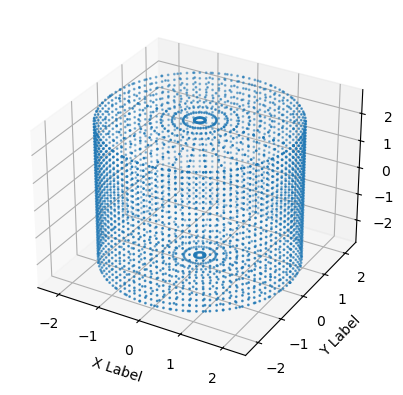

In [12]:
# Check the points are part of a cylinder
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

m = 'o'
ax.scatter(xs, ys, zs, marker=m, s = 1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Choose a resonant frequency and calculate the displacements

In [13]:
 Put all the eigenvalues in a long single array
decimals = 10
EIGVALS = numpy.concatenate(eigvals)#/(2*numpy.pi)
# Identify where in this long array a desired frequency repeats
EIGVALS = numpy.round(EIGVALS, decimals = decimals) # Truncate the decimal values to identify the frequencies
# EIGVALS = EIGVALS.sort() # sort the eigenvalues if needed
wsort = numpy.round(wsort, decimals = decimals) # Truncate the decimal values to identify the frequencies
index_of_frequency = 30 # Choose an index value from the list above.
pos = numpy.where(EIGVALS == wsort[index_of_frequency])[0] # Choose a frequency to plot and find its indices!!!
print('Indices where wsort equals the frequency: ', pos)
frequencies = 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi)
print('Frequencies: ', frequencies)
resonant_frequency = frequencies[0]

DU = numpy.zeros((len(locations),3))
i = 0
for loc in locations:
    dx, dy, dz = u_i(z, [loc[0], loc[1], loc[2]], [pos[0]]) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
    du=numpy.array([dx,dy,dz])
    #du_n = du/numpy.linalg.norm(du)
    DU[i,0] = du[0]
    DU[i,1] = du[1]
    DU[i,2] = du[2]
    i+=1

DU = numpy.array(DU)

NameError: name 'EIGVALS' is not defined

## Calculate the magnitude of displacements on the surface of the cylinder

In [ ]:
displacements = locations + 3*DU
xs = displacements[:,0]
ys = displacements[:,1]
zs = displacements[:,2]

abs_displacement = numpy.sqrt(DU[:, 0]**2 + DU[:, 1]**2 + DU[:, 2]**2)

## A snapshot of this mode
The locations on the sample are coloured using the absolute value of the amplitude of the displacement vector.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=12,
        color=numpy.sqrt(DU[:,0]**2 + DU[:,1]**2 + DU[:,2]**2),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.0,
        colorbar=dict(thickness=20)
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  # Remove axes from scene (comment this scene property if you want to see the axes)
                  scene = dict(
                      xaxis = dict(visible=False),
                      yaxis = dict(visible=False),
                      zaxis =dict(visible=False)
                      )
                  )
fig.show()

## Animate the movement

The displacement snapshot of a mode can be animated by multiplying the displacement at each position by a complex exponential at the resonant frequency. The cell below shows five cycles of oscillation of the resonant mode.  

In [ ]:
import plotly.graph_objects as go

# Assuming xs, ys, zs, resonant_frequency, and DU are defined from the previous code

T_r = 1/resonant_frequency # Period of the resonant frequency
time = numpy.linspace(0, 5*T_r, 100)  # Time from 0 to 5*T_r

frames = []
for t in time:
    complex_exp = numpy.exp(1j * resonant_frequency * 2 * numpy.pi * t)
    new_xs = locations[:,0] + 3*DU[:,0] * complex_exp.real
    new_ys = locations[:,1] + 3*DU[:,1] * complex_exp.real
    new_zs = locations[:,2] + 3*DU[:,2] * complex_exp.real

    frame = go.Frame(data=[go.Scatter3d(x=new_xs, y=new_ys, z=new_zs,
                                        mode='markers',
                                        marker=dict(
                                            size=8,
                                            color=abs_displacement,
                                            colorscale='Viridis',
                                            opacity=1.0
                                        ))],
                     name=str(t))
    frames.append(frame)

fig = go.Figure(
    data=[go.Scatter3d(x=locations[:,0], y=locations[:,1], z=locations[:,2], mode='markers',
                       marker=dict(size=8, color=abs_displacement,
                                   colorscale='Viridis', opacity=1.0))],
    frames=frames
)

fig.update_layout(
    title=f'{resonant_frequency:8.2f} Hz',
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 5, "redraw": True},
                                   "transition": {"duration": 0},
                                   "fromcurrent": True,
                                   "mode": "immediate"
                                   }]),
                 dict(label="Pause",
                      method="animate",
                      args=[[None], {"frame": {"duration": 0, "redraw": False},
                                     "mode": "immediate",
                                     "transition": {"duration": 0}}])
                 ])],
    # Remove axes from scene
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
        )
    )

scene = {
    # ...
    'aspectmode': 'cube',
}

fig.show()

## References

We used the following publications in this notebook:

- Visscher, W. M., Migliori, A., Bell, T. M., & Reinert, R. A. (1991). On the normal modes of free vibration of inhomogeneous and anisotropic elastic objects. The Journal of the Acoustical Society of America, 90(4), 2154-2162.
- Migliori, A., Sarrao, J. L., Visscher, W. M., Bell, T. M., Lei, M., Fisk, Z., & Leisure, R. G. (1993). Resonant ultrasound spectroscopic techniques for measurement of the elastic moduli of solids. Physica B: Condensed Matter, 183(1-2), 1-24.
- de Rue, J. (1996). On the normal modes of freely vibrating elastic objects of various shapes (MSc thesis, University of Amsterdam).
- Zadler, B. J., Le Rousseau, J. H., Scales, J. A., & Smith, M. L. (2004). Resonant ultrasound spectroscopy: theory and application. Geophysical Journal International, 156(1), 154-169.